В данном проекте реализуется попытка прогноза временного ряда(сальдо ликвидности Банкка).


Я добавил следующие параметры: ключевая ставка, инфляция, ВВП, налоговые дни, уровень безработицы, курс рубля к доллару.


Затем обработка данных и их визуализация.

Далее проверка ряда на стационарность(она показала, что ряд стационарен), поэтому проверяем, какой результат выдаст ARIMA(плохой)

Я выбрал в качестве основного алгоритма XGBoost. Метрики: MAE, RMSE, R2

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import seaborn as sns
from tsfresh import extract_features, select_features
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.feature_extraction import ComprehensiveFCParameters
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from xgboost import XGBRegressor




Эта часть кода меняет цветовую схему у matplotlib

In [2]:
from matplotlib import pyplot
def inverse_plot_colorscheme():
    import cycler
    def invert(color_to_convert): 
        table = str.maketrans('0123456789abcdef', 'fedcba9876543210')
        return '#' + color_to_convert[1:].lower().translate(table).upper()
    update_dict = {}
    for key, value in pyplot.rcParams.items():
        if value == 'black':
            update_dict[key] = 'white'
        elif value == 'white':
            update_dict[key] = 'black'
    
    old_cycle = pyplot.rcParams['axes.prop_cycle']
    new_cycle = []
    for value in old_cycle:
        new_cycle.append({
            'color': invert(value['color'])
        })
    pyplot.rcParams.update(update_dict)
    pyplot.rcParams['axes.prop_cycle'] = cycler.Cycler(new_cycle)
    lec = pyplot.rcParams['legend.edgecolor']
    lec = str(1 - float(lec))
    pyplot.rcParams['legend.edgecolor'] = lec

In [3]:
inverse_plot_colorscheme()

In [4]:
#  Загрузка и подготовка данных
df = pd.read_excel("df_final.xlsx")
df = df.sort_values("Date").reset_index(drop=True)
df.set_index("Date", inplace=True)
df = df.drop(columns = ['Inflation_y'])
df = df.iloc[1:].reset_index(drop=True)
df.head()





,Income,Outcome,Balance,TaxDay,GDP_year_total,USD_RUB,Unemployment,Inflation,KeyRate
0,1.068610,1.194182,-0.125572,0,1.574199,59.8961,5.6,5.0,10.0
1,0.944429,0.936663,0.007767,0,1.574199,59.9533,5.6,5.0,10.0
2,1.672202,0.875379,0.800391,0,1.574199,60.1614,5.6,5.0,10.0
3,0.955924,0.975645,-0.019721,1,1.574199,59.4978,5.6,5.0,10.0
4,0.000000,0.000000,0.000000,0,1.574199,59.3700,5.6,5.0,10.0


Визуализируем данные

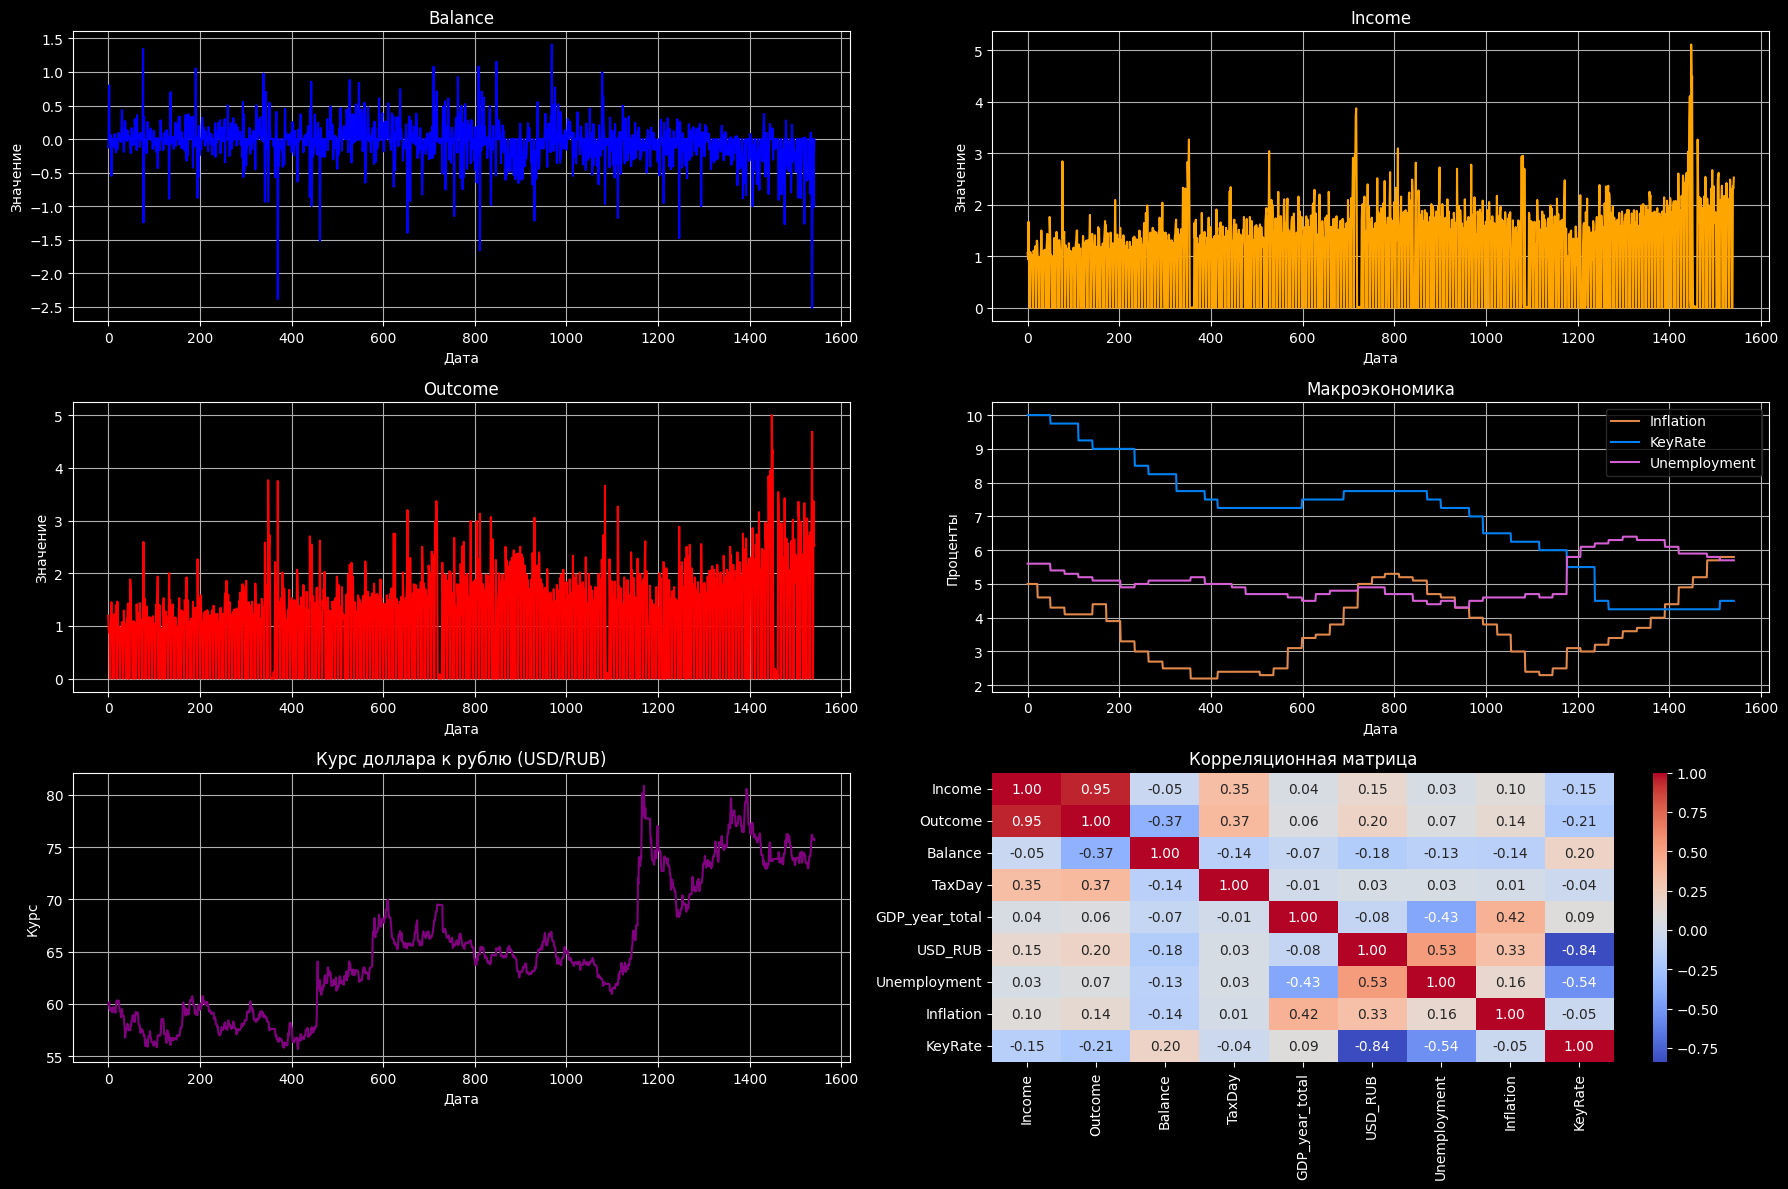

In [5]:

# Визуализация 
plt.figure(figsize=(18, 12))

# 1. Balance
plt.subplot(3, 2, 1)
plt.plot(df.index, df['Balance'], color='blue')
plt.title("Balance")
plt.xlabel("Дата")
plt.ylabel("Значение")
plt.grid(True)

# 2. Income
plt.subplot(3, 2, 2)
plt.plot(df.index, df['Income'], color='orange')
plt.title("Income")
plt.xlabel("Дата")
plt.ylabel("Значение")
plt.grid(True)

# 3. Outcome
plt.subplot(3, 2, 3)
plt.plot(df.index, df['Outcome'], color='red')
plt.title("Outcome")
plt.xlabel("Дата")
plt.ylabel("Значение")
plt.grid(True)

# 4. Макроэкономические показатели
plt.subplot(3, 2, 4)
for col in ['Inflation', 'KeyRate', 'Unemployment']:
    if col in df.columns:
        plt.plot(df.index, df[col], label=col)
plt.title("Макроэкономика")
plt.xlabel("Дата")
plt.ylabel("Проценты")
plt.legend()
plt.grid(True)

# 5. USD/RUB
plt.subplot(3, 2, 5)
plt.plot(df.index, df['USD_RUB'], color='purple')
plt.title("Курс доллара к рублю (USD/RUB)")
plt.xlabel("Дата")
plt.ylabel("Курс")
plt.grid(True)
# 6. Корреляционная матрица
plt.subplot(3, 2, 6)
sns.heatmap(df.corr(numeric_only=True), annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Корреляционная матрица")

plt.tight_layout()
plt.show()

In [6]:
# Тест Дики-Фуллера на стационарность
adf_result = adfuller(df['Balance'])
print("ADF Statistic:", adf_result[0])
print("p-value:", adf_result[1])

ADF Statistic: -4.110430871908425
p-value: 0.0009307804316848745


Временной ряд является стационарным, поэтому первое, что попытаемся сделать-обучим ARIMA


ARIMA((1, 0, 1)) METRICS:
MAE:  0.206
RMSE: 0.344
R²:   -0.233


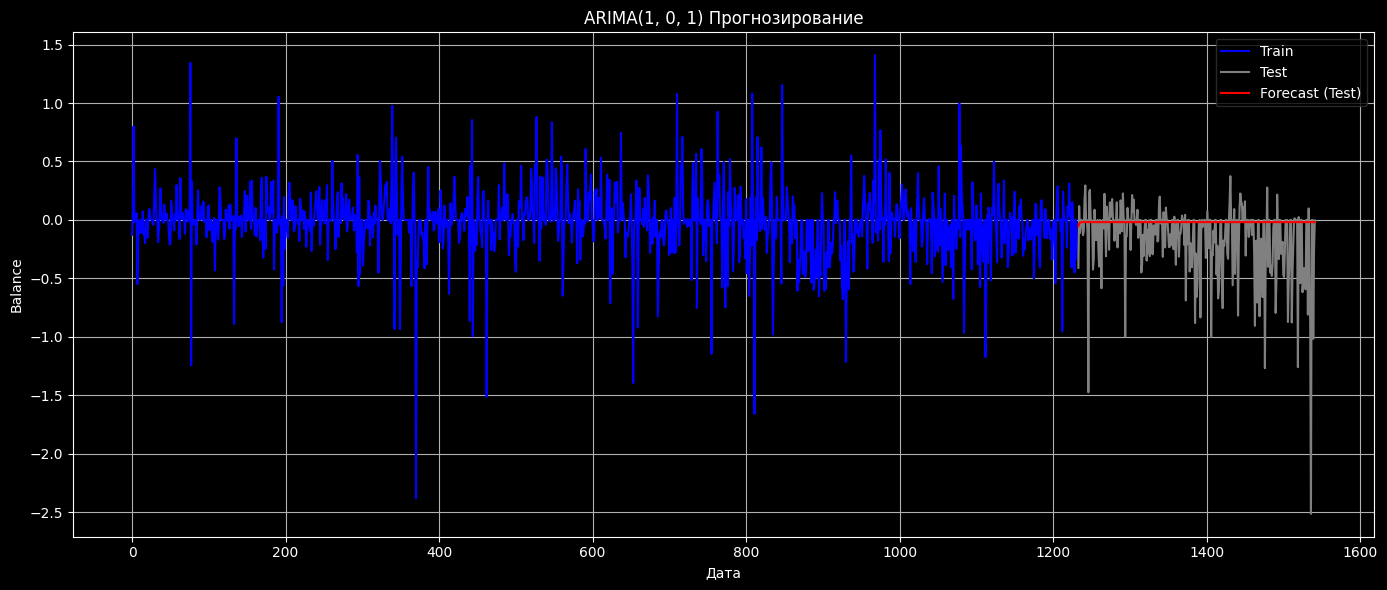

In [7]:
series = df['Balance']

#  Разделение на train/test 
train_size = int(len(series) * 0.8)
train, test = series[:train_size], series[train_size:]

#  Обучение ARIMA 

model = ARIMA(train, order=(1,0,1))
model_fit = model.fit()

# Прогноз 
forecast = model_fit.forecast(steps=len(test))

#  Метрики 
mae = mean_absolute_error(test, forecast)
rmse = np.sqrt(mean_squared_error(test, forecast))
r2 = r2_score(test, forecast)

print(f"\nARIMA({(1,0,1)}) METRICS:")
print(f"MAE:  {mae:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"R²:   {r2:.3f}")

# Визуализация 
plt.figure(figsize=(14, 6))
plt.plot(train.index, train, label='Train', color='blue')
plt.plot(test.index, test, label='Test', color='gray')
plt.plot(test.index, forecast, label='Forecast (Test)', color='red')
plt.title(f'ARIMA{1,0,1} Прогнозирование')
plt.xlabel('Дата')
plt.ylabel('Balance')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Работает плохо, поэтому извлечем с помощью tsfresh новые фичи и будем использовать при обучении модели ml

In [8]:
df["target"] = df["Balance"].shift(-10)
df = df.dropna(subset=["Balance", "target"]).reset_index(drop=True)

# Извлечение признаков с tsfresh 
df_tsfresh = pd.DataFrame({
    "id": df.index,
    "time": df.index,
    "value": df["Balance"]
})
features = extract_features(df_tsfresh, column_id="id", column_sort="time", column_value="value",
                            default_fc_parameters=ComprehensiveFCParameters(), n_jobs=0)
impute(features)
tsfresh_selected = select_features(features, df["target"])
tsfresh_selected = tsfresh_selected.reset_index(drop=True)
df.shape

Feature Extraction: 100%|██████████| 1532/1532 [01:45<00:00, 14.57it/s]
c:\Users\Юзер\AppData\Local\Programs\Python\Python310\lib\site-packages\tsfresh\utilities\dataframe_functions.py:198: RuntimeWarning: The columns ['value__mean_abs_change' 'value__mean_change'
 'value__mean_second_derivative_central' 'value__skewness'
 'value__kurtosis' 'value__sample_entropy' 'value__autocorrelation__lag_0'
 'value__autocorrelation__lag_1' 'value__autocorrelation__lag_2'
 'value__autocorrelation__lag_3' 'value__autocorrelation__lag_4'
 'value__autocorrelation__lag_5' 'value__autocorrelation__lag_6'
 'value__autocorrelation__lag_7' 'value__autocorrelation__lag_8'
 'value__autocorrelation__lag_9' 'value__partial_autocorrelation__lag_0'
 'value__partial_autocorrelation__lag_1'
 'value__partial_autocorrelation__lag_2'
 'value__partial_autocorrelation__lag_3'
 'value__partial_autocorrelation__lag_4'
 'value__partial_autocorrelation__lag_5'
 'value__partial_autocorrelation__lag_6'
 'value__partial_autoc

(1532, 10)

Fitting 5 folds for each of 120 candidates, totalling 600 fits


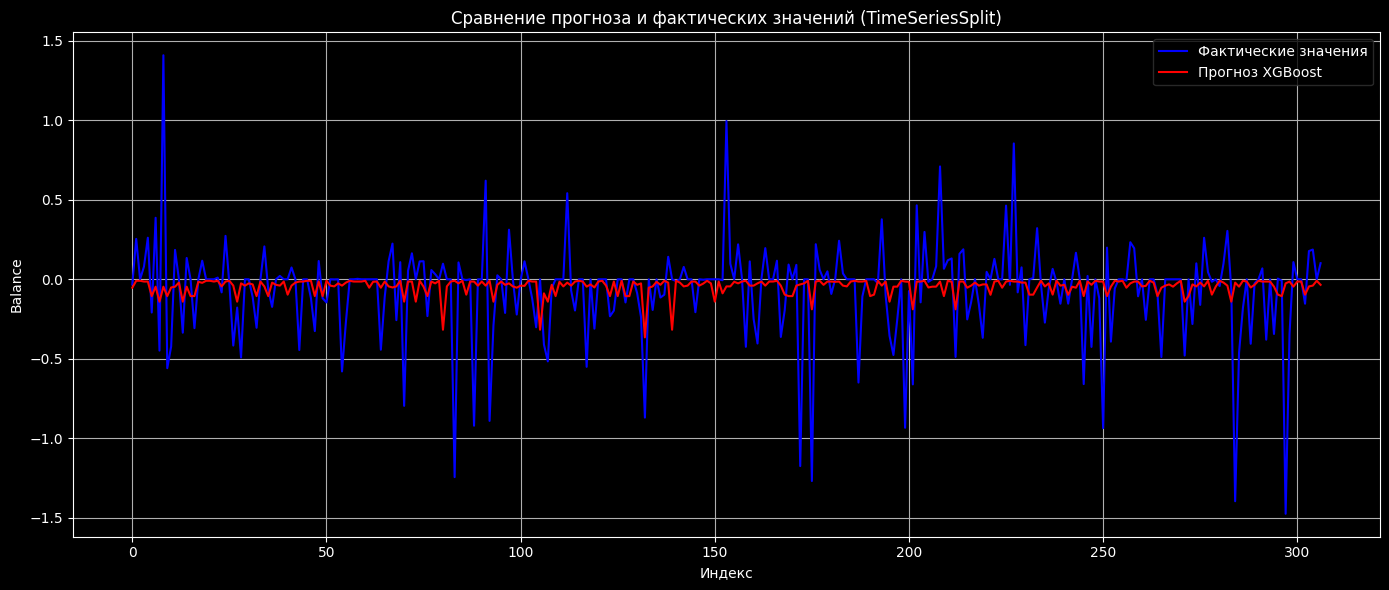

Лучшие параметры: {'model__learning_rate': 0.1, 'model__max_depth': 2, 'model__n_estimators': 10}
MAE:  0.178
RMSE: 0.298
R²:   0.033


In [ ]:

# Объединение с макроэкономическими фичами
macro = df[['Inflation', 'KeyRate', 'USD_RUB', 'Unemployment', 'TaxDay', 'GDP_year_total']].reset_index(drop=True)
X_full = pd.concat([tsfresh_selected, macro], axis=1)
y = df['target'].loc[X_full.index]


tscv = TimeSeriesSplit(n_splits=5)


pipeline = Pipeline([
    ('impute', SimpleImputer(strategy='mean')),
    ('scale', StandardScaler()),
    ('select', SelectKBest(score_func=f_regression, k=10)),
    ('model', XGBRegressor(objective='reg:squarederror', random_state=52))
])


param_grid = {
    'model__n_estimators': [5, 10, 30, 50, 100],
    'model__max_depth': [2,3, 4 , 5, 6, 7],
    'model__learning_rate': [0.1,0.05, 0.01, 0.001]
}

grid = GridSearchCV(pipeline, param_grid, cv=tscv,  scoring='r2', verbose=1)
X_train, X_test, y_train, y_test = train_test_split(
    X_full, y, test_size=0.2, shuffle=True, random_state=42)
grid.fit(X_train, y_train)
y_pred = grid.best_estimator_.predict(X_test)


# Визуализация прогноза 
plt.figure(figsize=(14, 6))
plt.plot(y_test.values, label='Фактические значения', color='blue')
plt.plot(y_pred, label='Прогноз XGBoost', color='red')
plt.title('Сравнение прогноза и фактических значений (TimeSeriesSplit)')
plt.xlabel('Индекс')
plt.ylabel('Balance')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f'Лучшие параметры: {grid.best_params_}')
print(f'MAE:  {mae:.3f}')
print(f'RMSE: {rmse:.3f}')
print(f'R²:   {r2:.3f}')


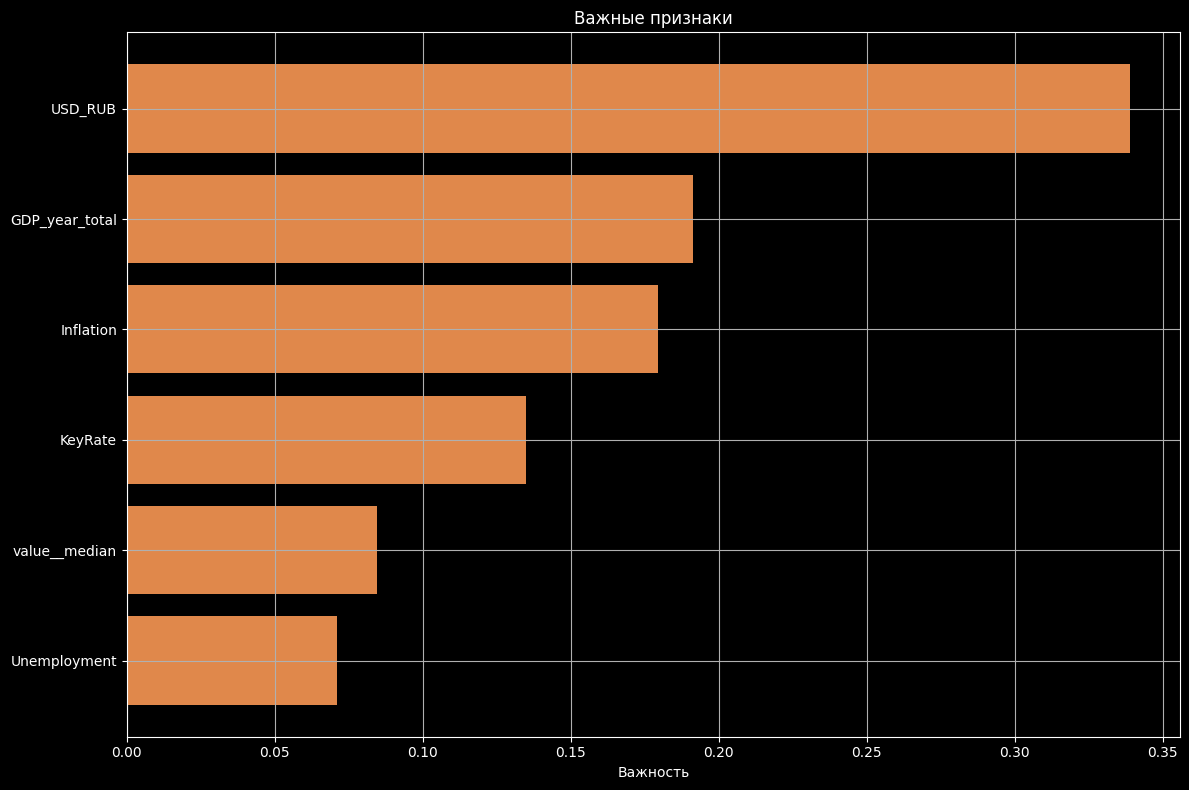

In [38]:

# Получаем признаки, отобранные SelectKBest
selector = grid.best_estimator_.named_steps['select']
selected_mask = selector.get_support()
selected_feature_names = X_full.columns[selected_mask]


model = grid.best_estimator_.named_steps['model']
importances = model.feature_importances_

nonzero_indices = np.where(importances > 0)[0]
filtered_importances = importances[nonzero_indices]
filtered_feature_names = [selected_feature_names[i] for i in nonzero_indices]

sorted_idx = np.argsort(filtered_importances)[::-1]
sorted_importances = filtered_importances[sorted_idx]
sorted_feature_names = [filtered_feature_names[i] for i in sorted_idx]


plt.figure(figsize=(12, 8))
plt.barh(range(len(sorted_importances)), sorted_importances, align='center')
plt.yticks(range(len(sorted_importances)), sorted_feature_names)
plt.xlabel("Важность")
plt.title("Важные признаки")
plt.gca().invert_yaxis()
plt.grid(True)
plt.tight_layout()
plt.show()
